getting data from kaggle

In [11]:
import os
import json

with open('../root/.config/kaggle/kaggle.json','w') as f:
  # i dont care if public
  key = {"username":"anol666666666","key":"cbee873743914476519082917584e4a0"}
  f.write(
      json.dumps(key)
  )

os.listdir('../root/.config/kaggle')

os.system(r'kaggle competitions download -c challenges-in-representation-learning-facial-expression-recognition-challenge')
os.listdir()


['.config',
 'challenges-in-representation-learning-facial-expression-recognition-challenge.zip',
 'sample_data']

In [14]:
# now make folder structure. I am pushing a square peg into a round hole here because collab is just so awkward
# and I need it to work with the code I've already written locally

os.makedirs('AdvancedAI/CA2/notebooks',exist_ok = True)
os.makedirs('AdvancedAI/CA2/data/01 Raw',exist_ok = True)
os.makedirs('AdvancedAI/CA2/data/02 Processed',exist_ok = True)

os.rename('challenges-in-representation-learning-facial-expression-recognition-challenge.zip',
          'AdvancedAI/CA2/data/01 Raw/data.zip')

In [15]:
# now unzip
import zipfile
import os

zip_file_path = 'AdvancedAI/CA2/data/01 Raw/data.zip'
destination_folder = 'AdvancedAI/CA2/data/01 Raw/'

# Extract the zip file
with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall(destination_folder)


In [16]:
# keeping necessary stuff
directory = 'AdvancedAI/CA2/data/01 Raw'
for f in os.listdir(directory):
  if f == 'train.csv':
    continue
  else:
    os.remove(os.path.join(directory,f))

exploration

In [17]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

try:
  os.chdir('AdvancedAI/CA2/notebooks/')
except:
  pass

path = '../data/01 Raw/train.csv'
df = pd.read_csv(path)

In [18]:
df.columns = df.columns.map(lambda x: x.strip().lower())
x = df.pixels.str.split().explode().astype(int).values

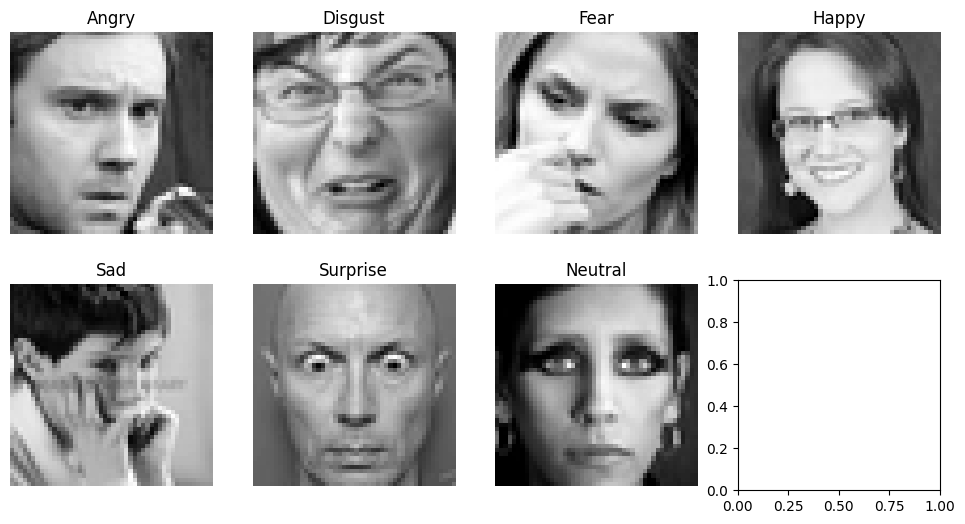

In [19]:
labels = {0 : 'Angry',
              1 : 'Disgust',
              2 : 'Fear',
              3 : 'Happy',
              4 : 'Sad',
              5 : 'Surprise',
              6 : 'Neutral'}
X = x.reshape(-1,48,48)

fig, ax = plt.subplots(2, 4, figsize=(12, 6))
for i in range(7):
    idx = df.loc[df.emotion == i].index[0]
    ax[i//4, i%4].imshow(X[idx], cmap='gray')
    ax[i//4, i%4].set_title(labels[i])
    ax[i//4, i%4].axis('off')

In [20]:
df.emotion.value_counts(normalize=True)

,proportion
emotion,
3,0.251315
6,0.172942
4,0.168240
2,0.142708
0,0.139155
5,0.110453
1,0.015187


In [21]:
(
    df.assign(label=df.emotion.map(labels))
    .groupby('label')
    .agg(count = ('pixels', 'count'))
    .plot(kind='bar', backend='plotly')
    .update_layout(title='Distribution of Emotions in Training Set',showlegend=False)
)


In [22]:
from sklearn.model_selection import train_test_split

df_train, df_test = train_test_split(df, test_size=0.2, stratify=df.emotion, random_state=42)
df_train.emotion.value_counts()

,count
emotion,
3,5772
6,3972
4,3864
2,3277
0,3196
5,2537
1,349


In [23]:
df_test.emotion.value_counts()

,count
emotion,
3,1443
6,993
4,966
2,820
0,799
5,634
1,87


In [24]:
from sklearn.utils import resample

def balance_labels(df, label_col):
    max_count = df[label_col].value_counts().max()
    balanced = pd.concat([
        resample(group, replace=True, n_samples=max_count, random_state=42)
        for _, group in df.groupby(label_col)
    ])
    return balanced.sample(frac=1, random_state=42).reset_index(drop=True)

df_balanced = balance_labels(df_train, 'emotion')

In [25]:
(
    df_balanced.assign(label=df_balanced.emotion.map(labels))
    .groupby('label')
    .agg(count = ('pixels', 'count'))
    .plot(kind='bar', backend='plotly')
    .update_layout(title='Distribution of Emotions in Training Set',showlegend=False)
)

In [26]:
df_balanced.to_pickle('../data/02 Processed/balancedData.pkl')
df_test.to_pickle('../data/02 Processed/testData.pkl')

Data Processing

In [27]:
import os
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split

try:
  os.chdir('AdvancedAI/CA2/notebooks')
except:
  pass

df = pd.read_pickle("../data/02 Processed/balancedData.pkl")

In [28]:
# Data enrichment
df.drop(columns=["usage"], inplace=True, errors="ignore")
images = df.pixels.str.split().explode().astype(int).values.reshape(-1,48,48)

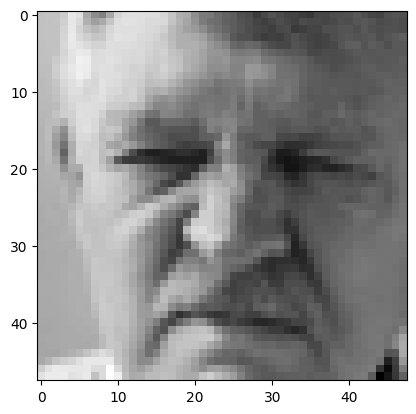

In [29]:
import matplotlib.pyplot as plt
testImage = images[0]
plt.imshow(testImage, cmap="gray")

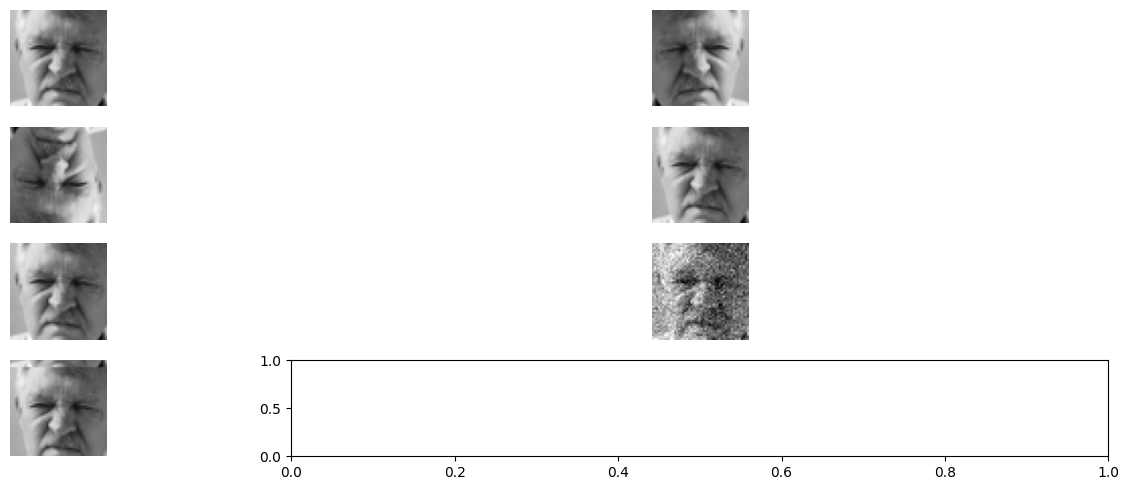

In [30]:
def horizontal_flip(image):
    return np.fliplr(image)
def random_rotation(image):
    angle = np.random.randint(0, 360)
    return np.rot90(image, k=angle//90)
def random_brightness(image):
    factor = np.random.uniform(0.5, 1.5)
    return np.clip(image * factor, 0, 255).astype(np.uint8)
def random_contrast(image):
    factor = np.random.uniform(0.5, 1.5)
    mean = np.mean(image)
    return np.clip((image - mean) * factor + mean, 0, 255).astype(np.uint8)
def random_noise(image):
    noise = np.random.normal(0, 25, image.shape)
    return np.clip(image + noise, 0, 255).astype(np.uint8)
def random_translation(image):
    tx = np.random.randint(-5, 6)
    ty = np.random.randint(-5, 6)
    return np.roll(np.roll(image, tx, axis=1), ty, axis=0)


# plt.imshow(horizontal_flip(testImage), cmap="gray")
# plt.imshow(random_rotation(testImage), cmap="gray")
# plt.imshow(random_brightness(testImage), cmap="gray")
# plt.imshow(random_contrast(testImage), cmap="gray")
# plt.imshow(random_noise(testImage), cmap="gray")
# plt.imshow(random_translation(testImage), cmap="gray")
# plt.imshow(random_zoom(testImage), cmap="gray")

plots = [
    testImage,
    horizontal_flip(testImage),
    random_rotation(testImage),
    random_brightness(testImage),
    random_contrast(testImage),
    random_noise(testImage),
    random_translation(testImage),
]
fig, axes = plt.subplots(4, 2, figsize=(15, 5))

for ax, img in zip(axes.flatten(), plots):
    ax.imshow(img, cmap="gray")
    ax.axis("off")
plt.tight_layout()
plt.show()


def augment_image(image:np.ndarray)-> np.ndarray:
    '''
    one 48x48 image is passed
    returns 10 augmented images

    shape of return will be (10, 48, 48). Goal is then to have overall shape as (len(df),10, 48, 48)
    Then it can be exploded and then flattend down to the string again
    '''
    augmented_images = []

    augmented_images.append(image)
    operations = [
        horizontal_flip,
        random_rotation,
        random_brightness,
        random_contrast,
        random_noise,
        random_translation,
    ]
    for operation in operations:
        augmented_images.append(operation(image))

    # Randomly select 3 images from the augmented images
    selection = np.random.choice(list(range(7)), 3, replace=False)
    for idx in selection:
        # randomly select a function from the list
        fn = np.random.choice(operations)
        augmented_images.append(fn(augmented_images[idx]))
    return np.array(augmented_images)


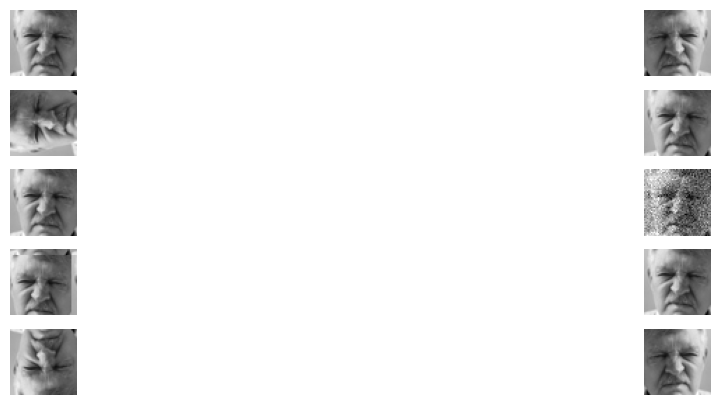

In [31]:
res = augment_image(testImage)


fig, axes = plt.subplots(5, 2, figsize=(15, 5))
for ax, img in zip(axes.flatten(), res):
    ax.imshow(img, cmap="gray")
    ax.axis("off")

In [32]:
testShape = np.array([augment_image(img) for img in images[:3]])
# shape should be (3,10,48,48)
print(testShape.shape)

(3, 10, 48, 48)


In [33]:
testDF = pd.DataFrame(data = dict(emotion = df.emotion[:3].values.tolist(), pixels = df.pixels[:3].values.tolist()))
augmentations = []
for augmentedBatch in testShape:
    res = ''
    for img in augmentedBatch:
        res += ' '.join(map(str, img.flatten())) + '\n'
    res = res.strip()
    augmentations.append(res)

testDF["augmentated_pixels"] = augmentations

(
    testDF
    .assign(augmentated_pixels = lambda s: s.augmentated_pixels.str.split("\n"))
    .explode("augmentated_pixels")

)

,emotion,pixels,augmentated_pixels
0,1,186 188 187 196 221 214 165 140 130 164 204 21...,186 188 187 196 221 214 165 140 130 164 204 21...
0,1,186 188 187 196 221 214 165 140 130 164 204 21...,87 88 86 74 77 86 93 87 85 84 77 77 64 69 74 7...
0,1,186 188 187 196 221 214 165 140 130 164 204 21...,102 64 34 14 96 124 121 117 113 103 100 100 96...
0,1,186 188 187 196 221 214 165 140 130 164 204 21...,110 111 111 116 131 127 98 83 77 97 121 126 12...
0,1,186 188 187 196 221 214 165 140 130 164 204 21...,170 171 170 177 194 189 155 137 130 154 182 18...
0,1,186 188 187 196 221 214 165 140 130 164 204 21...,150 225 187 151 206 223 137 101 131 161 193 19...
0,1,186 188 187 196 221 214 165 140 130 164 204 21...,165 165 168 180 192 188 178 163 146 112 107 15...
0,1,186 188 187 196 221 214 165 140 130 164 204 21...,51 52 51 44 45 51 55 51 50 49 45 45 38 41 44 4...
0,1,186 188 187 196 221 214 165 140 130 164 204 21...,246 247 246 255 255 255 224 198 188 223 255 25...
0,1,186 188 187 196 221 214 165 140 130 164 204 21...,83 83 84 90 96 94 89 82 73 56 53 78 91 94 94 9...


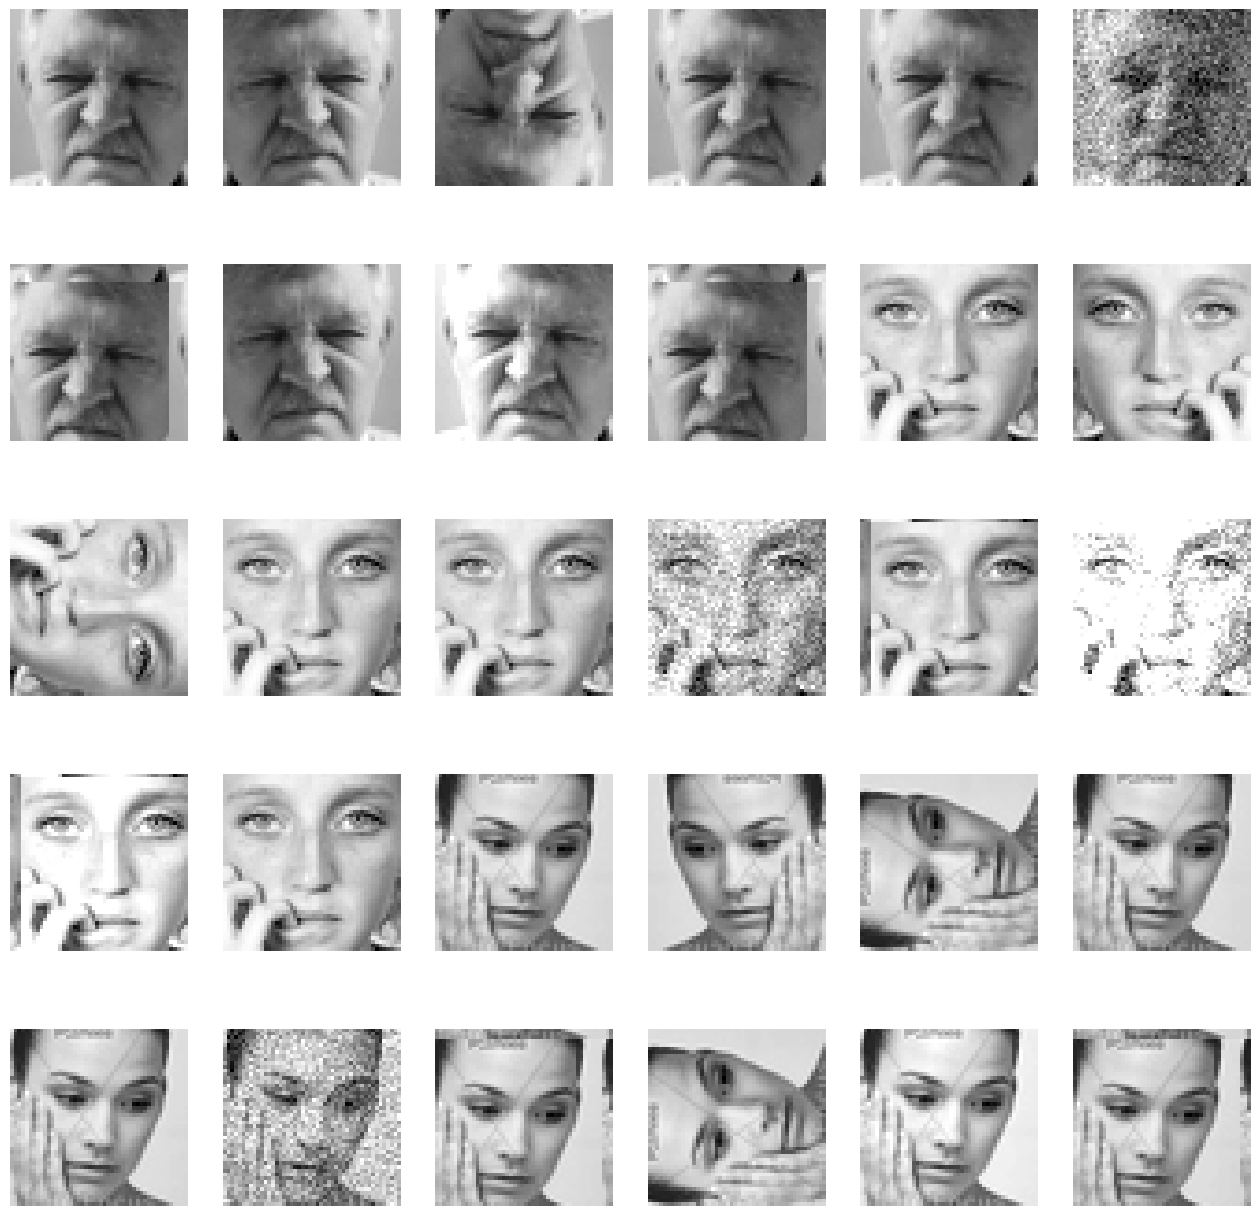

In [34]:

test_ims = (
    testDF
    .assign(augmentated_pixels = lambda s: s.augmentated_pixels.str.split("\n"))
    .explode("augmentated_pixels")
    .augmentated_pixels.str.split().explode().astype(int).values.reshape(-1,48,48)
)

fig, axes = plt.subplots(5, 6, figsize=(16,16))
for ax, img in zip(axes.flatten(), test_ims):
    ax.imshow(img, cmap="gray")
    ax.axis("off")

In [35]:
augmentedBatches = np.array([augment_image(img) for img in images])
print(augmentedBatches.shape) # shape should be (len(df),10,48,48)
augmentedImageStrings = []
for augmentedBatch in augmentedBatches:
    res = ''
    for img in augmentedBatch:
        res += ' '.join(map(str, img.flatten())) + '\n'
    res = res.strip()
    augmentedImageStrings.append(res)
    print("{}/{}".format(len(augmentedImageStrings), len(augmentedBatches)), end = '\r')

print(len(augmentedImageStrings))

df["augmentated_pixels"] = augmentedImageStrings

AugmentedDataFrame = (
    df
    .assign(augmentated_pixels = lambda s: s.augmentated_pixels.str.split("\n"))
    .explode("augmentated_pixels")
    # .reset_index(drop=True)
)

print(AugmentedDataFrame.shape)
print(df.shape)

AugmentedDataFrame = (
    AugmentedDataFrame
    .assign(pixels = AugmentedDataFrame.augmentated_pixels)
    .drop(columns = 'augmentated_pixels')
)

AugmentedDataFrame.to_pickle("../data/02 Processed/train.pkl")

(40404, 10, 48, 48)
40404
(404040, 3)
(40404, 3)


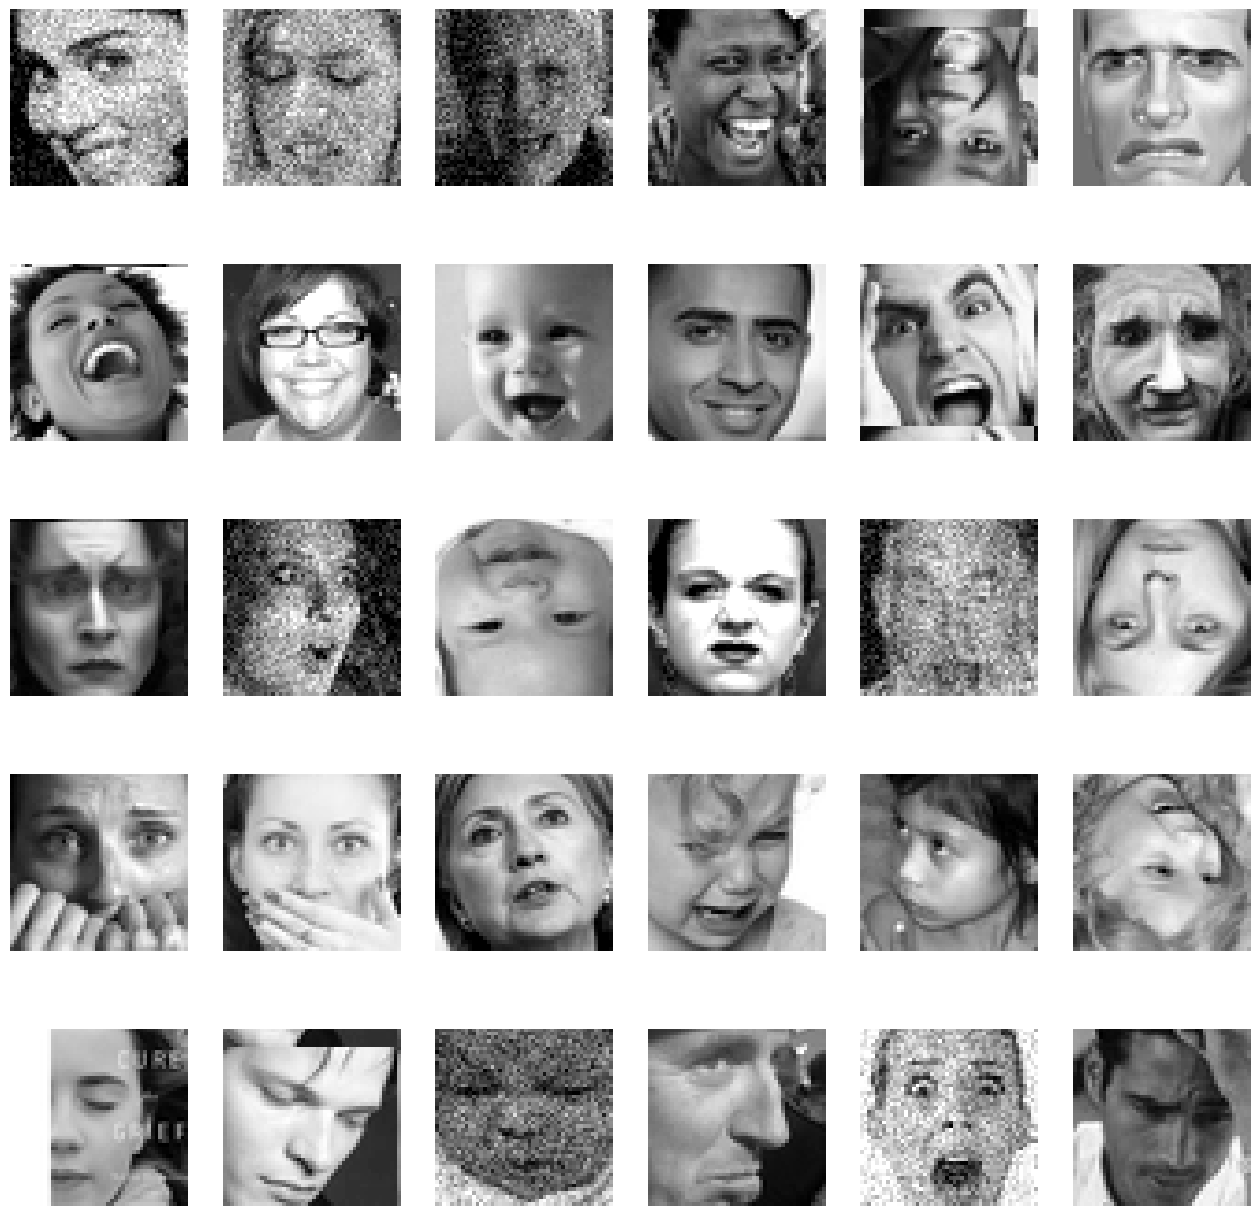

In [38]:
# Randomly select 30 images from AugmentedDataFrame
sample_images = (
    AugmentedDataFrame.reset_index(drop=True)
    .pipe(lambda s: s.loc[np.random.choice(s.index,30)])
    .pixels
    .str.split().explode().astype(int).values.reshape(-1,48,48)
)

fig, axes = plt.subplots(5, 6, figsize=(16,16))
for ax, img in zip(axes.flatten(), sample_images):
    ax.imshow(img, cmap="gray")
    ax.axis("off")

02 pipeline.ipynb


In [39]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Dataset
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing._data import BaseEstimator, TransformerMixin, OneToOneFeatureMixin
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler


In [41]:
TrainingData = pd.read_pickle('../data/02 Processed/train.pkl')
FinalTestData = pd.read_pickle('../data/02 Processed/testData.pkl')
# s = TrainingData.iloc[:1000].copy()
# del TrainingData
# TrainingData = s.copy()
# del s

FinalTestData.shape, TrainingData.shape
TrainingDataCheckPoint = TrainingData.copy()

In [42]:
big,small = train_test_split(TrainingData, test_size=0.02, stratify=TrainingData['emotion'], random_state=42)

<Axes: xlabel='emotion'>

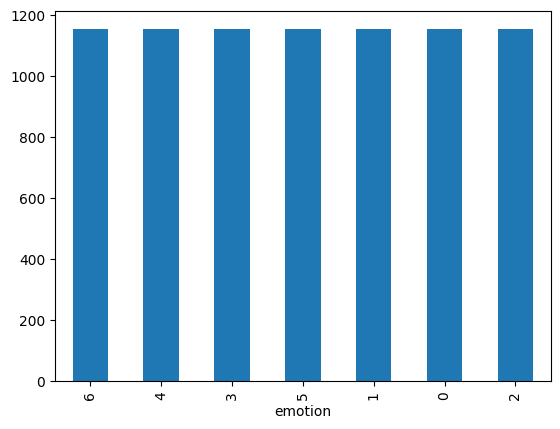

In [43]:
small.emotion.value_counts().plot(kind='bar')

<Axes: xlabel='emotion'>

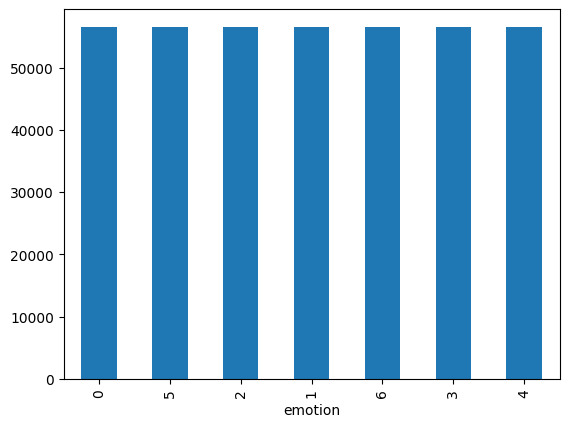

In [44]:
big.emotion.value_counts().plot(kind='bar')

In [45]:
TrainingData = small

In [ ]:
# TrainingData = TrainingData.iloc[:5]

In [ ]:
# TrainingData = TrainingDataCheckPoint.drop_duplicates().reset_index(drop=True)

In [46]:

class CustomStandardScaler(OneToOneFeatureMixin, TransformerMixin, BaseEstimator):
    def __init__(self, mu: float, sigma: float):
        self.mu = mu
        self.sigma = sigma
        self.__mean = None
        self.__std = None
        self.__fitted = False

    @property
    def _fitted(self)->bool:
        return self.__fitted

    @_fitted.setter
    def _fitted(self, value: bool):
        if self.__fitted:
            raise AttributeError("The 'fit' method has already been called.")
        if not isinstance(value, bool):
            raise TypeError("The 'fitted' attribute must be a boolean.")
        self.__fitted = value

    @property
    def _mean(self)->np.ndarray:
        '''
        mean of the passed data
        '''
        if self.__mean is None:
            raise AttributeError("The 'fit' method must be called before accessing the mean.")
        return self.__mean

    @property
    def _std(self)->np.ndarray:
        '''
        std of the passed data
        '''
        if self.__std is None:
            raise AttributeError("The 'fit' method must be called before accessing the std.")
        return self.__std

    def fit(self, X: np.ndarray)-> 'CustomStandardScaler':
        self._fitted = True
        self.__mean = X.mean(axis=0)
        self.__std = X.std(axis=0)
        return self

    def transform(self, X: np.ndarray)-> np.ndarray:
        newX = X - self._mean
        newX = (newX / self._std) * self.sigma
        return newX+self.mu

    def fit_transform(self, X:np.ndarray) -> np.ndarray:
        self.fit(X)
        return self.transform(X)

    def inverse_transform(self, X:np.ndarray) -> np.ndarray:
        newX = X - self.mu
        newX = (newX / self._std) * self.sigma
        return newX + self._mean

class CustomMinMaxScaler(OneToOneFeatureMixin, TransformerMixin, BaseEstimator):
    def __init__(self):
        self.__min = None
        self.__max = None
        self.__fitted = False

    @property
    def _fitted(self)->bool:
        return self.__fitted

    @_fitted.setter
    def _fitted(self, value: bool):
        if self.__fitted:
            raise AttributeError("The 'fit' method has already been called.")
        if not isinstance(value, bool):
            raise TypeError("The 'fitted' attribute must be a boolean.")
        self.__fitted = value

    @property
    def _min(self)->np.ndarray:
        '''
        min of the passed data
        '''
        if self.__min is None:
            raise AttributeError("The 'fit' method must be called before accessing the min.")
        return self.__min

    @property
    def _max(self)->np.ndarray:
        '''
        max of the passed data
        '''
        if self.__max is None:
            raise AttributeError("The 'fit' method must be called before accessing the max.")
        return self.__max

    def fit(self, X: np.ndarray)-> 'CustomStandardScaler':
        self._fitted = True
        self.__min = X.min(axis=0)
        self.__max = X.max(axis=0)
        return self

    def transform(self, X: np.ndarray)-> np.ndarray:
        return (X - self._min)/(self._max - self._min)

    def fit_transform(self, X:np.ndarray) -> np.ndarray:
        self.fit(X)
        return self.transform(X)

    def inverse_transform(self, X:np.ndarray) -> np.ndarray:
        return X * (self._max - self._min) + self._min

class Data(Dataset):
    _identityFunc = lambda x: x
    def __init__(self,data:pd.DataFrame, transform:transforms = None, scaler:BaseEstimator = None):
        # making them private so can't be altered
        if not scaler:
            scaler = CustomScaler(0, 0.25)

        self.__transform = transform if transform else Data._identityFunc
        self.__Y = data['emotion'].astype(int).values.tolist()
        self.__X = data.pixels.str.split().explode().astype(np.uint8).values.reshape(-1,48,48)
        self.__len = data.shape[0]
        try:
            self.__X = scaler.fit_transform(self.__X).astype(np.float32)
        except AttributeError:
            print("Already fit")
            self.__X = scaler.transform(self.__X).astype(np.float32)

    def __len__(self)->int:
        return self.__len

    def __getitem__(self, index)->tuple[np.ndarray,np.ndarray]:
        img:np.ndarray = self.__X[index]
        emotion:int = self.__Y[index]
        label = np.zeros((7,), dtype=np.float32)
        label[emotion] = 1
        return self.__transform(img), label

class CNN(nn.Module):
    def __init__(self, num_classes):
        super(CNN, self).__init__()

        self.conv1 = nn.Sequential(
            nn.Conv2d(1, 16, kernel_size=5, padding=2),
            nn.ReLU(),
            nn.MaxPool2d(2, 2)
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(16, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2)
        )
        self.fc1 = nn.Sequential(
            nn.Linear(32 * 12 * 12, 256),
            nn.LeakyReLU(),
        )
        self.fc2 = nn.Sequential(
            nn.Linear(256, 100),
            nn.Sigmoid()
        )
        self.fc3 = nn.Sequential(
            nn.Linear(100, num_classes),
            nn.Softmax(dim=1)
        )

    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = x.flatten(start_dim=1)
        x = self.fc1(x)
        x = self.fc2(x)
        x = self.fc3(x)
        return x



In [47]:

def train(model, dataloader, criterion, optimizer, device):
    model.train()
    running_loss = 0.0
    for images, labels in dataloader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

        # get accuracy
        predicted = outputs.argmax(axis=1)
        target = labels.argmax(axis=1)
        correct = (predicted == target).sum().item()
        accuracy = correct / labels.size(0)
    return running_loss / len(dataloader), accuracy

def evaluate(model, dataloader, criterion, device):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
      for images, labels in dataloader:
          images, labels = images.to(device), labels.to(device)
          outputs = model(images)
          loss = criterion(outputs, labels)
          running_loss += loss.item()
          predicted = outputs.argmax(axis=1)
          total += labels.size(0)
          correct += (predicted == labels.argmax(axis = 1)).sum().item()

    return running_loss / len(dataloader), correct / total

In [48]:
class CustomLoss(nn.Module):
    '''
    nn.CrossEntropyLosss is annoying me the way it expects labels
    it also does the softmax part itself.

    this class expects two R^n vectors or two arrays of R^n vectors
    it then penalises the difference using negative log liklihood
    '''
    def __init__(self):
        super(CustomLoss, self).__init__()
    def forward(self, probabilites:torch.Tensor, target:torch.Tensor)->torch.Tensor:
        '''
        probabilites: R^n
        target: R^n
        '''
        # print(probabilites)
        # print(target)
        # print(probabilites.shape)
        # print(target.shape)
        return -torch.sum(target * torch.log(probabilites + 1e-10), dim=1).mean()

In [52]:
torch.cuda.is_available()

False

In [49]:
transformers = transforms.Compose([
    transforms.ToTensor(),
])

print('fitting scaler')
scaler = CustomStandardScaler(0, 0.25) #<- Pretty good - 37% accuracy on test set, 95% on training set

scaler.fit(TrainingData.pixels.str.split().explode().astype(np.uint8).values.reshape(-1,48,48))

print('making dataset')
train_data = Data(TrainingData, transform=transformers, scaler=scaler)
test_data = Data(FinalTestData, transform=transformers, scaler=scaler)

print('making dataloader')
train_loader = DataLoader(train_data, shuffle = True, batch_size=503370)
test_loader = DataLoader(test_data, batch_size=7178, shuffle = True)

print('making model')
num_classes = 7
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = CNN(num_classes).to(device)
# criterion = nn.CrossEntropyLoss()
criterion = CustomLoss()
optimizer = optim.Adam(model.parameters(), lr=.01)

num_epochs = 100

print('backward')
for epoch in range(num_epochs):
    train_loss, train_accuracy = train(model, train_loader, criterion, optimizer, device)
    test_loss, accuracy = evaluate(model, test_loader, criterion, device)
    print(f"Epoch [{epoch+1}/{num_epochs}], \
    Train Loss: {train_loss:.4f}, \
    Train Accuracy: {train_accuracy:.4f}, \
    Test Loss: {test_loss:.4f}, \
    Accuracy: {accuracy:.4f}")

fitting scaler
making dataset
Already fit
Already fit
making dataloader
making model
backward
Epoch [1/100],     Train Loss: 1.9584,     Train Accuracy: 0.1428,     Test Loss: 2.2853,     Accuracy: 0.1682
Epoch [2/100],     Train Loss: 2.3982,     Train Accuracy: 0.1429,     Test Loss: 2.0512,     Accuracy: 0.1278
Epoch [3/100],     Train Loss: 1.9766,     Train Accuracy: 0.1573,     Test Loss: 1.9385,     Accuracy: 0.1592
Epoch [4/100],     Train Loss: 1.9509,     Train Accuracy: 0.1515,     Test Loss: 1.9370,     Accuracy: 0.1395
Epoch [5/100],     Train Loss: 1.9486,     Train Accuracy: 0.1407,     Test Loss: 1.9572,     Accuracy: 0.1660
Epoch [6/100],     Train Loss: 1.9404,     Train Accuracy: 0.1762,     Test Loss: 1.9342,     Accuracy: 0.2311
Epoch [7/100],     Train Loss: 1.9308,     Train Accuracy: 0.1845,     Test Loss: 1.9188,     Accuracy: 0.2360
Epoch [8/100],     Train Loss: 1.9308,     Train Accuracy: 0.1833,     Test Loss: 1.9448,     Accuracy: 0.2001
Epoch [9/100],    

KeyboardInterrupt: 

In [ ]:
transformers = transforms.Compose([
    transforms.ToTensor(),
])

print('fitting scaler')
scaler = CustomMinMaxScaler()

scaler.fit(TrainingData.pixels.str.split().explode().astype(np.uint8).values.reshape(-1,48,48))

print('making dataset')
train_data = Data(TrainingData, transform=transformers, scaler=scaler)
test_data = Data(FinalTestData, transform=transformers, scaler=scaler)

print('making dataloader')
train_loader = DataLoader(train_data, shuffle = True, batch_size=503370)
test_loader = DataLoader(test_data, batch_size=7178, shuffle = True)

print('making model')
num_classes = 7
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = CNN(num_classes).to(device)
# criterion = nn.CrossEntropyLoss()
criterion = CustomLoss()
optimizer = optim.Adam(model.parameters(), lr=.01)

num_epochs = 100

print('backward')
for epoch in range(num_epochs):
    train_loss, train_accuracy = train(model, train_loader, criterion, optimizer, device)
    test_loss, accuracy = evaluate(model, test_loader, criterion, device)
    print(f"Epoch [{epoch+1}/{num_epochs}], \
    Train Loss: {train_loss:.4f}, \
    Train Accuracy: {train_accuracy:.4f}, \
    Test Loss: {test_loss:.4f}, \
    Accuracy: {accuracy:.4f}")

fitting scaler
making dataset
Already fit
Already fit
making dataloader
making model
backward
Epoch [1/100],     Train Loss: 2.0129,     Train Accuracy: 0.1428,     Test Loss: 2.1385,     Accuracy: 0.1728
Epoch [2/100],     Train Loss: 2.2200,     Train Accuracy: 0.1429,     Test Loss: 1.9417,     Accuracy: 0.1694
Epoch [3/100],     Train Loss: 1.9575,     Train Accuracy: 0.1428,     Test Loss: 1.9852,     Accuracy: 0.0152
Epoch [4/100],     Train Loss: 1.9497,     Train Accuracy: 0.1428,     Test Loss: 1.9615,     Accuracy: 0.1427
Epoch [5/100],     Train Loss: 1.9488,     Train Accuracy: 0.1428,     Test Loss: 1.9408,     Accuracy: 0.1427
Epoch [6/100],     Train Loss: 1.9472,     Train Accuracy: 0.1428,     Test Loss: 1.9292,     Accuracy: 0.2350
Epoch [7/100],     Train Loss: 1.9465,     Train Accuracy: 0.1490,     Test Loss: 1.9344,     Accuracy: 0.2545
Epoch [8/100],     Train Loss: 1.9489,     Train Accuracy: 0.1471,     Test Loss: 1.9481,     Accuracy: 0.0318
Epoch [9/100],    

KeyboardInterrupt: 

In [ ]:
# for images, labels in train_loader:
#     print(1)

y = model(images).argmax(axis=1)

In [ ]:
yhat = labels.argmax(axis=1)

In [ ]:
yhat

tensor([4, 3, 2,  ..., 4, 3, 1])

In [ ]:
(y == yhat).sum().item()/len(yhat)

0.9295788637266588